# Part B: Unsupervised Learning

## Imports

In [13]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import plotly.express as px
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import f_classif
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [ ]:
df = pd.read_csv('../data/preprocessed/final_dataset.csv')
df.head()

/tmp/ipykernel_113/2559327521.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/preprocessed/final_dataset.csv')


id                         listing_url       scrape_id last_scraped  \
0   3083   https://www.airbnb.com/rooms/3083  20250925032724   2025-09-25   
1   5739   https://www.airbnb.com/rooms/5739  20250925032724   2025-09-25   
2  24916  https://www.airbnb.com/rooms/24916  20250925032724   2025-09-25   
3  29521  https://www.airbnb.com/rooms/29521  20250925032724   2025-09-25   
4  30026  https://www.airbnb.com/rooms/30026  20250925032724   2025-09-25   

        source                                               name  \
0  city scrape                             Room #2 - West Oakland   
1  city scrape                                         Mod Studio   
2  city scrape       Studio w/garden and Patio close to Rockridge   
3  city scrape                             Elegant Rockridge Home   
4  city scrape  Temescal sunny townhome w/views every room 3 d...   

                                         description  \
0  4 blocks from West Oakland BART, 1 stop to San...   
1  The Mod Studio is a cozy, clean and convenient...   
2  Studio with patio garden just out the door.  <...   
3  Lovely, light-filled, upper level 2BD/1 BA Que...   
4  This is a 3 level penthouse in the heart of Te...   

                               neighborhood_overview  \
0  The neighborhood is in a historic district wit...   
1  We love the proximity to great restaurants, Wh...   
2  great neighborhood, for walking , beautiful ga...   
3  Centrally located, walking distance to Whole F...   
4  Original Temescal, centrally located near free...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/hosting/Hosti...     3518  ...   
1  https://a0.muscache.com/pictures/116966/376a1f...     9276  ...   
2  https://a0.muscache.com/pictures/hosting/Hosti...    98716  ...   
3  https://a0.muscache.com/pictures/09205cda-384c...   124220  ...   
4  https://a0.muscache.com/pictures/miso/Hosting-...    98716  ...   

  log_dist_km_downtown log_dist_km_airport source_city_LA source_city_OAK  \
0             1.097442            2.542756              0               1   
1             0.906212            2.456451              0               1   
2             1.500451            2.607292              0               1   
3             1.565652            2.648236              0               1   
4             1.489207            2.646392              0               1   

  source_city_SD source_city_SF  source_city_nan  listing_age_years  \
0              0              0                0          11.156164   
1              0              0                0          16.210959   
2              0              0                0          15.252055   
3              0              0                0          14.186301   
4              0              0                0          13.052055   

   reviews_per_year bathrooms_per_bedroom  
0          6.498760                  1.00  
1         19.406240                  1.00  
2          9.106541                  1.00  
3          3.358290                  0.50  
4          0.355820                  0.75  

[5 rows x 115 columns]

## Data Cleaning: Handling Missing Values

The majority of the data cleaning / pre processing has been done in the EDA workbook. 

I will ascess the amount of NA values left in the final dataset and drop columns that we have determined to be irrelevant, duplicative, high NA, or causing issues in our modeling due to skew, high NA count etc.

I will also dropped all listings that have no reviews so we can maintain review information for our clusters. 

In [15]:
nan_pct = (df.isna().sum() / len(df)) * 100
print(nan_pct[nan_pct > 0].sort_values(ascending=False))

calendar_updated                100.000000
license                          54.079616
neighbourhood                    44.583213
neighborhood_overview            44.583213
host_about                       39.100240
neighbourhood_group_cleansed     35.952038
host_location                    19.779376
estimated_revenue_l365d          16.907434
host_neighbourhood               16.400959
host_response_time               15.010072
crime_count                       8.247482
has_availability                  2.710791
description                       1.034053
bathrooms_text                    0.128537
host_verifications                0.084412
host_picture_url                  0.084412
host_thumbnail_url                0.084412
host_since                        0.084412
host_total_listings_count         0.084412
host_name                         0.082494
minimum_maximum_nights            0.059472
maximum_maximum_nights            0.059472
maximum_minimum_nights            0.059472
minimum_min

In [16]:
df = df[df['number_of_reviews'] > 0]

In [17]:
drop_cols = [
    # id, urls, text
    
    # "id", -- keeping this for graphing
    # "listing_url", -- keeping this for graphing
    "scrape_id",
    "last_scraped",
    "source", 
    #"picture_url", -- keeping this for graphing
    "last_scraped",
    "calendar_last_scraped",
    "calendar_updated",
    "name",
    "description",
    "neighborhood_overview",
    "host_about",
    "host_id",
    "host_url",
    "host_name",
    "host_location",
    "host_thumbnail_url",
    "host_picture_url",
    "host_neighbourhood",
    "host_verifications",

    # neighborhood
    "neighbourhood",
    "neighbourhood_group_cleansed",

    
   # future looking 
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    
    "minimum_nights_avg_ntm", 
    "maximum_nights_avg_ntm",

    # redundant
    #"host_total_listings_count", -- keeping for clustering
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",

    # review related redundant
    "review_scores_accuracy",
    #"review_scores_cleanliness", -- keeping for clustering
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",

    # others / objects
    "license",
    "bathrooms_text",
    "calendar_updated",
    "calendar_last_scraped",
    "last_review",

    # spatial join related
    "geometry",
    "ALAND", # area of the land in sq mt
    "index_right", # result of spatial join

    # dont know the definitions / redundant
    "availability_eoy",
    "number_of_reviews_ly",
    "estimated_occupancy_l365d",
    "estimated_revenue_l365d",

    # leaks info 
    'has_availability',
    'availability_30',
    'availability_60',
    'availability_90',
    #'availability_365', -- keeping for clustering

    # no: of reviews redundant
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    #'reviews_per_month' -- keeping for clustering

    # used to create other features, now redundant
    "amenities", # counts are created
    "host_since", # host_years is created 
    "crime_count", # nomalized
    "population", # nomalized
    "price_per_person",  # keeping price instead
    "amenities_list", # already tranformed to counts 
    'host_response_time', # ordinal is created for this
    
    # one hot encoded columns
    'room_type',
    'source_city',
   

    # log transformations are already there
    #'dist_km_downtown', -- keeping for visualization 
    #'dist_km_airport', -- keeping for visualization 


    # already calculated in years
    'first_review',

    # location based features - already have log distances
    'GEOID',
    'neighbourhood_cleansed',
    #'latitude', -- keeping for clustering
    #'longitude', -- keep for clustering

    
    'property_type',

    # normlaized by year
    'number_of_reviews', 


    # dummy variable trap
    'source_city_LA',
    "source_city_OAK",
    "source_city_SD",
    "source_city_SF",
    'source_city_nan',
    'room_type_Entire home/apt', 
    'room_type_nan',

    # created new
    #'bathrooms', -- keeping for clustering
    #'beds', -- keeping for clustering
    'bathrooms_per_bedroom',

    # location 
    "area_sqmiles",
    "crime_per_1000", # too skewed

# irrelevant
'host_has_profile_pic', 
'host_identity_verified',
'host_total_listings_count', 
]


In [18]:
cols_drop_valid = [col for col in drop_cols if col in df.columns]
df.drop(columns=cols_drop_valid, inplace=True)

nan_pct_updated = (df.isna().sum() / len(df)) * 100
print(nan_pct_updated[nan_pct_updated > 0].sort_values(ascending=False))

review_scores_cleanliness    0.013429
population_per_sqmile        0.001918
dtype: float64


In [19]:
df = df.copy().dropna()
df.head()

id                         listing_url  \
0   3083   https://www.airbnb.com/rooms/3083   
1   5739   https://www.airbnb.com/rooms/5739   
2  24916  https://www.airbnb.com/rooms/24916   
3  29521  https://www.airbnb.com/rooms/29521   
4  30026  https://www.airbnb.com/rooms/30026   

                                         picture_url  host_response_rate  \
0  https://a0.muscache.com/pictures/hosting/Hosti...                1.00   
1  https://a0.muscache.com/pictures/116966/376a1f...                1.00   
2  https://a0.muscache.com/pictures/hosting/Hosti...                0.88   
3  https://a0.muscache.com/pictures/09205cda-384c...                1.00   
4  https://a0.muscache.com/pictures/miso/Hosting-...                0.88   

   host_acceptance_rate  host_is_superhost  host_listings_count   latitude  \
0                  1.00                1.0                  7.0  37.810130   
1                  0.96                1.0                  1.0  37.812663   
2                  0.88                0.0                  2.0  37.831690   
3                  0.95                1.0                  3.0  37.836180   
4                  0.88                0.0                  2.0  37.834500   

    longitude  accommodates  ...  is_unique_stay  population_per_sqmile  \
0 -122.292660             2  ...               0            8629.627187   
1 -122.258047             2  ...               0           42807.868225   
2 -122.251750             2  ...               0           14353.997712   
3 -122.255810             4  ...               0           13352.896439   
4 -122.262640             2  ...               0           16687.748272   

   crime_per_sqmile  host_years  dist_km_downtown  dist_km_airport  \
0       1791.054699       16.98          1.996492        11.714659   
1       5375.179280       16.57          1.474930        10.663343   
2       2506.831296       15.52          3.483709        12.562274   
3       2350.221689       15.38          3.785794        13.129088   
4       6035.110669       15.52          3.433579        13.103068   

   log_dist_km_downtown  log_dist_km_airport  listing_age_years  \
0              1.097442             2.542756          11.156164   
1              0.906212             2.456451          16.210959   
2              1.500451             2.607292          15.252055   
3              1.565652             2.648236          14.186301   
4              1.489207             2.646392          13.052055   

   reviews_per_year  
0          6.498760  
1         19.406240  
2          9.106541  
3          3.358290  
4          0.355820  

[5 rows x 38 columns]

In [20]:
len(df) #.columns

52117

## Data Transformations

Now I will scale our data for the clustering exercise. I am removing all one-hot-encoded columns and lat / long from the scaling / transformation exercise because I do not want rare items such as is_unique_stay to be overly weighted by scaling.

In [15]:
df_scaled = df.copy()

right_skewed_outliers = [
    "price",
    "population_per_sqmile",
    "crime_per_sqmile"
]

def log_transform(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

log_transform(df_scaled,right_skewed_outliers)

id                                       listing_url  \
0                     3083                 https://www.airbnb.com/rooms/3083   
1                     5739                 https://www.airbnb.com/rooms/5739   
2                    24916                https://www.airbnb.com/rooms/24916   
3                    29521                https://www.airbnb.com/rooms/29521   
4                    30026                https://www.airbnb.com/rooms/30026   
...                    ...                                               ...   
68982  1510363690728387697  https://www.airbnb.com/rooms/1510363690728387697   
68997  1511671555507582581  https://www.airbnb.com/rooms/1511671555507582581   
69001  1511805535052171919  https://www.airbnb.com/rooms/1511805535052171919   
69002  1511852295309010333  https://www.airbnb.com/rooms/1511852295309010333   
69008  1512469177318328103  https://www.airbnb.com/rooms/1512469177318328103   

                                             picture_url  host_response_rate  \
0      https://a0.muscache.com/pictures/hosting/Hosti...                1.00   
1      https://a0.muscache.com/pictures/116966/376a1f...                1.00   
2      https://a0.muscache.com/pictures/hosting/Hosti...                0.88   
3      https://a0.muscache.com/pictures/09205cda-384c...                1.00   
4      https://a0.muscache.com/pictures/miso/Hosting-...                0.88   
...                                                  ...                 ...   
68982  https://a0.muscache.com/pictures/hosting/Hosti...                1.00   
68997  https://a0.muscache.com/pictures/hosting/Hosti...                1.00   
69001  https://a0.muscache.com/pictures/prohost-api/H...                1.00   
69002  https://a0.muscache.com/pictures/hosting/Hosti...                1.00   
69008  https://a0.muscache.com/pictures/hosting/Hosti...                0.97   

       host_acceptance_rate  host_is_superhost  host_listings_count  \
0                      1.00                1.0                  7.0   
1                      0.96                1.0                  1.0   
2                      0.88                0.0                  2.0   
3                      0.95                1.0                  3.0   
4                      0.88                0.0                  2.0   
...                     ...                ...                  ...   
68982                  1.00                0.0                  1.0   
68997                  0.98                0.0                  4.0   
69001                  1.00                0.0                 30.0   
69002                  0.92                0.0                  2.0   
69008                  0.91                1.0                  4.0   

        latitude   longitude  accommodates  ...  is_unique_stay  \
0      37.810130 -122.292660             2  ...               0   
1      37.812663 -122.258047             2  ...               0   
2      37.831690 -122.251750             2  ...               0   
3      37.836180 -122.255810             4  ...               0   
4      37.834500 -122.262640             2  ...               0   
...          ...         ...           ...  ...             ...   
68982  32.716572 -117.157598             2  ...               0   
68997  32.761481 -117.136652             2  ...               0   
69001  32.713751 -117.159809             7  ...               0   
69002  32.836580 -117.276570             4  ...               0   
69008  32.719380 -117.090970            10  ...               0   

       population_per_sqmile  crime_per_sqmile  host_years  dist_km_downtown  \
0                   9.063072          7.491118       16.98          1.996492   
1                  10.664501          8.589733       16.57          1.474930   
2                   9.571853          7.827174       15.52          3.483709   
3                   9.499563          7.762690       15.38          3.785794   
4                   9.722490          8.7055

In [16]:
df_scaled.columns

Index(['id', 'listing_url', 'picture_url', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_365',
       'review_scores_rating', 'review_scores_cleanliness', 'instant_bookable',
       'reviews_per_month', 'NatWalkInd', 'host_response_time_ord',
       'safety_amenities_count', 'convenience_amenities_count',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'is_unique_stay', 'population_per_sqmile',
       'crime_per_sqmile', 'host_years', 'dist_km_downtown', 'dist_km_airport',
       'log_dist_km_downtown', 'log_dist_km_airport', 'listing_age_years',
       'reviews_per_year'],
      dtype='object')

In [17]:
# Identify numerical columns excluding 'latitude' and 'longitude'
do_not_scale_columns = ['id', 'listing_url', 'picture_url', 'host_is_superhost','latitude',
       'longitude','instant_bookable', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'is_unique_stay', 'dist_km_downtown', 'dist_km_airport']
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
features_to_scale = [col for col in numerical_cols if col not in do_not_scale_columns]

# Initialize StandardScaler
scaler = StandardScaler()


# Apply StandardScaler to the selected features
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("Numerical features (excluding latitude and longitude) have been scaled using StandardScaler.")
print("First 5 rows of the scaled features:")
print(df_scaled[features_to_scale].head())

Numerical features (excluding latitude and longitude) have been scaled using StandardScaler.
First 5 rows of the scaled features:
   host_response_rate  host_acceptance_rate  host_listings_count  \
0            0.461089              0.534874            -0.123728   
1            0.461089              0.473363            -0.138972   
2            0.292776              0.350341            -0.136431   
3            0.461089              0.457985            -0.133890   
4            0.292776              0.350341            -0.136431   

   accommodates  bathrooms  bedrooms      beds     price  minimum_nights  \
0     -0.749393  -0.277060 -0.521440 -0.498300 -0.092648       -0.465537   
1     -0.749393  -0.277060 -1.296852 -0.498300 -0.106166       -0.363818   
2     -0.749393  -0.277060 -1.296852  0.028003 -0.107517       -0.363818   
3     -0.058312  -0.277060  0.253973  0.028003 -0.036322       -0.329912   
4     -0.749393   0.185583  0.253973  0.028003 -0.073722        0.212591   

   m

### PCA First Pass

PCA has been fitted and transformed on the scaled numerical features.


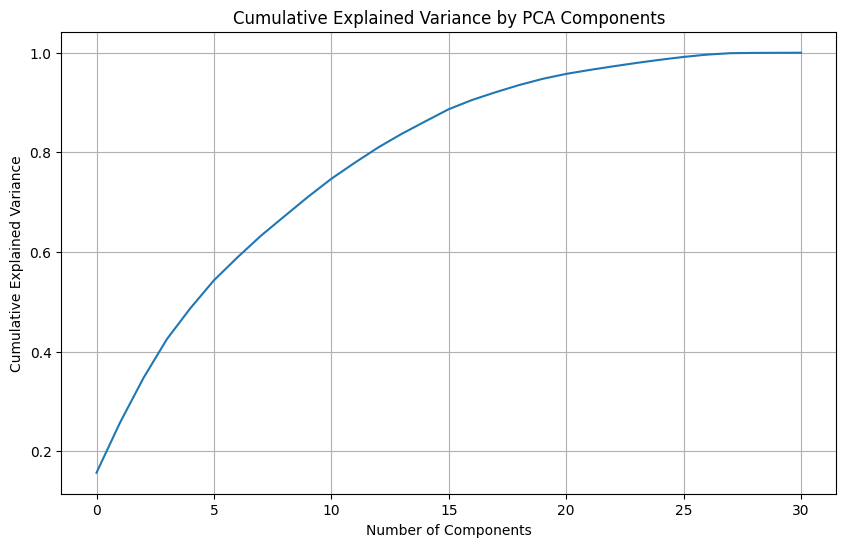

Explained variance ratio for each component:
[0.15696967 0.10044713 0.08975967 0.07813582 0.06205198 0.05578646
 0.04599489 0.04344096 0.03909916 0.03880143 0.03654072 0.03227242
 0.03068422 0.02730348 0.02489652 0.02449644 0.01859513 0.01553825
 0.01435688 0.0124384  0.00990858 0.00791443 0.00723208 0.00688064
 0.00632816 0.00569049 0.0046358  0.00290298 0.00054597 0.00018974
 0.00016149]
Cumulative explained variance:
[0.15696967 0.2574168  0.34717647 0.42531229 0.48736427 0.54315073
 0.58914563 0.63258658 0.67168574 0.71048717 0.74702789 0.77930031
 0.80998454 0.83728801 0.86218453 0.88668097 0.9052761  0.92081435
 0.93517123 0.94760963 0.95751821 0.96543264 0.97266473 0.97954537
 0.98587353 0.99156402 0.99619982 0.99910279 0.99964876 0.99983851
 1.        ]


In [18]:
features = [col for col in numerical_cols if col not in ['id', 'latitude', 'longitude', 'listing_url',
 'picture_url', 'dist_km_downtown', 'dist_km_airport']]

# Instantiate PCA with n_components=None to retain all components
pca = PCA(n_components=None)

# Fit PCA to the scaled numerical features and transform the data
df_pca = pca.fit_transform(df_scaled[features])

print("PCA has been fitted and transformed on the scaled numerical features.")

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Print the explained variance ratio for each principal component and their cumulative sum
print("Explained variance ratio for each component:")
print(pca.explained_variance_ratio_)
print("Cumulative explained variance:")
print(np.cumsum(pca.explained_variance_ratio_))

### PCA Second Pass: Retain Principal Components making up 80% of Variance

In [19]:
# Instantiate PCA to capture 80% of the total variance
pca_adjusted = PCA(n_components=0.80)

# Fit PCA to the scaled numerical features and transform the data
df_pca_adjusted = pca_adjusted.fit_transform(df_scaled[features])

print("PCA has been re-fitted with n_components=0.80 and transformed on the scaled numerical features.")

# Print the shape of the new PCA-transformed data
print(f"Shape of PCA-transformed data (df_pca_adjusted): {df_pca_adjusted.shape}")

# Print the cumulative explained variance ratio for the adjusted PCA model
print("Cumulative explained variance ratio for the adjusted PCA model:")
print(pca_adjusted.explained_variance_ratio_.sum())

PCA has been re-fitted with n_components=0.80 and transformed on the scaled numerical features.
Shape of PCA-transformed data (df_pca_adjusted): (52117, 13)
Cumulative explained variance ratio for the adjusted PCA model:
0.8099845357315036


### Understanding the Principal Components

In [20]:
loadings = pd.DataFrame(
    pca_adjusted.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_adjusted.n_components_)],
    index=features
)

loadings.head()

def interpret_pc(loadings, pc, top_n=3):
    print(f"\n==== {pc} ====")
    print("\nTop Positive:")
    print(loadings[pc].sort_values(ascending=False).head(top_n))
    
    print("\nTop Negative:")
    print(loadings[pc].sort_values().head(top_n))

In [21]:
loadings


PC1       PC2       PC3       PC4       PC5  \
host_response_rate           0.253607  0.339214  0.112388  0.219137 -0.297742   
host_acceptance_rate         0.246935  0.329215  0.145255  0.204541 -0.196888   
host_is_superhost            0.066216  0.063373  0.110708 -0.025356 -0.053639   
host_listings_count         -0.017672  0.093570 -0.131255  0.113129 -0.033845   
accommodates                 0.372678 -0.086263 -0.234386 -0.195241  0.167092   
bathrooms                    0.371489 -0.000796 -0.197470 -0.092965 -0.008119   
bedrooms                     0.368622 -0.120402 -0.249450 -0.190970  0.101669   
beds                         0.397295 -0.014538 -0.190915 -0.148107  0.080740   
price                        0.028491  0.041489 -0.100917  0.028192  0.007494   
minimum_nights              -0.127509 -0.088788 -0.156973 -0.078250 -0.162550   
maximum_nights              -0.008869 -0.009353 -0.018798 -0.000442 -0.008305   
availability_365             0.181828  0.135656 -0.052079  0.181297 -0.128798   
review_scores_rating         0.056748 -0.045572  0.281879 -0.421679 -0.356844   
review_scores_cleanliness    0.062231 -0.012270  0.287281 -0.402313 -0.349206   
instant_bookable             0.030686  0.047436 -0.014080  0.041764  0.060703   
reviews_per_month            0.145699  0.217987  0.425088 -0.034540  0.403598   
NatWalkInd                  -0.124034  0.285282 -0.142082 -0.171350  0.035813   
host_response_time_ord       0.113625  0.198026 -0.031911  0.139074 -0.412844   
safety_amenities_count       0.141831  0.036013  0.057463 -0.149261 -0.008774   
convenience_amenities_count  0.207459 -0.063472 -0.040823 -0.074806 -0.011861   
room_type_Hotel room        -0.001003  0.004427 -0.005122  0.005001  0.001295   
room_type_Private room      -0.067158 -0.006500  0.025831  0.061287 -0.013384   
room_type_Shared room       -0.001240  0.001170 -0.000523  0.001521  0.000941   
is_unique_stay              -0.002622  0.002690  0.000835  0.002091 -0.001857   
population_per_sqmile       -0.180969  0.335165 -0.213070 -0.125813  0.016689   
crime_per_sqmile            -0.146774  0.358449 -0.221673 -0.132406  0.043294   
host_years                  -0.091358 -0.066709  0.032709 -0.298811 -0.160723   
log_dist_km_downtown         0.145337 -0.415982  0.193360  0.244258 -0.070361   
log_dist_km_airport          0.027476 -0.253951  0.076641  0.246376 -0.091396   
listing_age_years           -0.164471 -0.112167  0.049546 -0.277221 -0.001780   
reviews_per_year             0.111271  0.200393  0.441830 -0.094413  0.388983   

                                  PC6       PC7       PC8       PC9      PC10  \
host_response_rate          -0.124445  0.014918 -0.004777 -0.039822  0.017488   
host_acceptance_rate        -0.042162  0.010498 -0.049457 -0.063651  0.044663   
host_is_superhost           -0.022610 -0.002002 -0.002813 -0.049255  0.028167   
host_listings_count          0.226127  0.592518  0.088395  0.059543 -0.079871   
accommodates                 0.028831 -0.020348  0.036018  0.018407 -0.015450   
bathrooms                   -0.071112 -0.057825  0.150884  0.115627 -0.070847   
bedrooms                     0.001678 -0.034107  0.064034  0.015807 -0.020215   
beds                        -0.065317 -0.069356  0.121649  0.090303 -0.055697   
price                        0.233704  0.645847  0.067558  0.090118 -0.156346   
minimum_nights              -0.122291  0.019765 -0.081389 -0.065084  0.116650   
maximum_nights              -0.034173  0.100098  0.076943  0.502409  0.847451   
availability_365            -0.113177  0.056335  0.112815  0.152496 -0.048445   
review_scores_rating         0.286680 -0.052368  0.039021  0.108629 -0.043738   
review_scores_cleanliness    0.323425 -0.025376  0.037595  0.125571 -0.047501   
instant_bookable             0.059986  0.029194 -0.023106  0.027263 -0.000894   
reviews_per_month           -0.012860  0.021639  0.082756  0.025417  0.008081   
NatWalkInd                  -0.072508 -0.019295 -0.355816  0.196

In [22]:
# Meaning: Listing Capacity vs Urban
interpret_pc(loadings, 'PC1')


==== PC1 ====

Top Positive:
beds            0.397295
accommodates    0.372678
bathrooms       0.371489
Name: PC1, dtype: float64

Top Negative:
population_per_sqmile   -0.180969
listing_age_years       -0.164471
crime_per_sqmile        -0.146774
Name: PC1, dtype: float64


In [23]:
# Meaning: Urban Amenaties vs Density
interpret_pc(loadings, 'PC2')


==== PC2 ====

Top Positive:
crime_per_sqmile         0.358449
host_response_rate       0.339214
population_per_sqmile    0.335165
Name: PC2, dtype: float64

Top Negative:
log_dist_km_downtown   -0.415982
log_dist_km_airport    -0.253951
bedrooms               -0.120402
Name: PC2, dtype: float64


In [24]:
# Meaning: High Engagement vs Low
interpret_pc(loadings, 'PC3')


==== PC3 ====

Top Positive:
reviews_per_year             0.441830
reviews_per_month            0.425088
review_scores_cleanliness    0.287281
Name: PC3, dtype: float64

Top Negative:
bedrooms           -0.249450
accommodates       -0.234386
crime_per_sqmile   -0.221673
Name: PC3, dtype: float64


### K\-Means First Pass

Next I will use the PCs that contain 80% of the data's variance to performa a first pass of the K-Means clustering. This will likely still have too much noise in the data since I still have a lot of principal components included

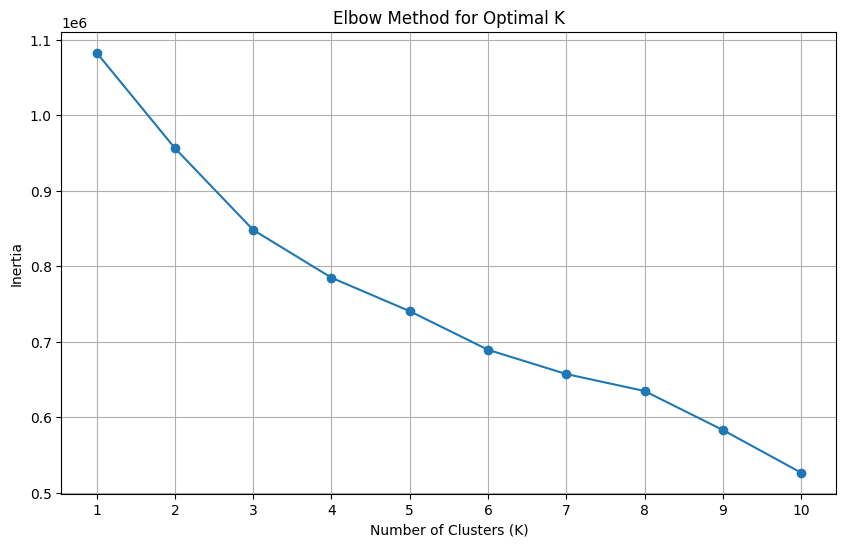

The Elbow method plot has been generated to help determine the optimal number of clusters.


In [25]:
# Define a range for the number of clusters (K)
k_range = range(1, 11)

# Create an empty list to store inertia values
inertia_values = []

# Loop through each value of k in the k_range
for k in k_range:
    # Instantiate a KMeans object with n_clusters=k, random_state=42, and n_init='auto'
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    
    # Fit the KMeans model to the PCA-transformed data
    kmeans.fit(df_pca_adjusted)
    
    # Append the inertia_ attribute of the fitted model to the inertia_values list
    inertia_values.append(kmeans.inertia_)

# Create a plot with k_range on the x-axis and inertia_values on the y-axis
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')

# Add labels and title to the plot
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.xticks(k_range)

# Display the plot
plt.show()

print("The Elbow method plot has been generated to help determine the optimal number of clusters.")

In [26]:
# Optimal K identified from the Elbow method plot
optimal_k = 4 # Visually chosen from the plot where the elbow is most prominent

# Instantiate KMeans with the optimal K
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')

# Fit the KMeans model to the PCA-transformed data (df_pca_adjusted)
kmeans_model.fit(df_pca_adjusted)

# Predict the cluster labels
cluster_labels = kmeans_model.predict(df_pca_adjusted)

# Add the cluster labels to the original DataFrame 'df'
df['kmeans4_PC_80pct'] = cluster_labels

print(f"K-means clustering applied with K={optimal_k}. Cluster labels added to 'df'.")
print("First 5 rows with new 'kmeans4_PC_80pct' column:")
print(df[['kmeans4_PC_80pct']].head())

K-means clustering applied with K=4. Cluster labels added to 'df'.
First 5 rows with new 'kmeans4_PC_80pct' column:
   kmeans4_PC_80pct
0                 3
1                 0
2                 3
3                 3
4                 0


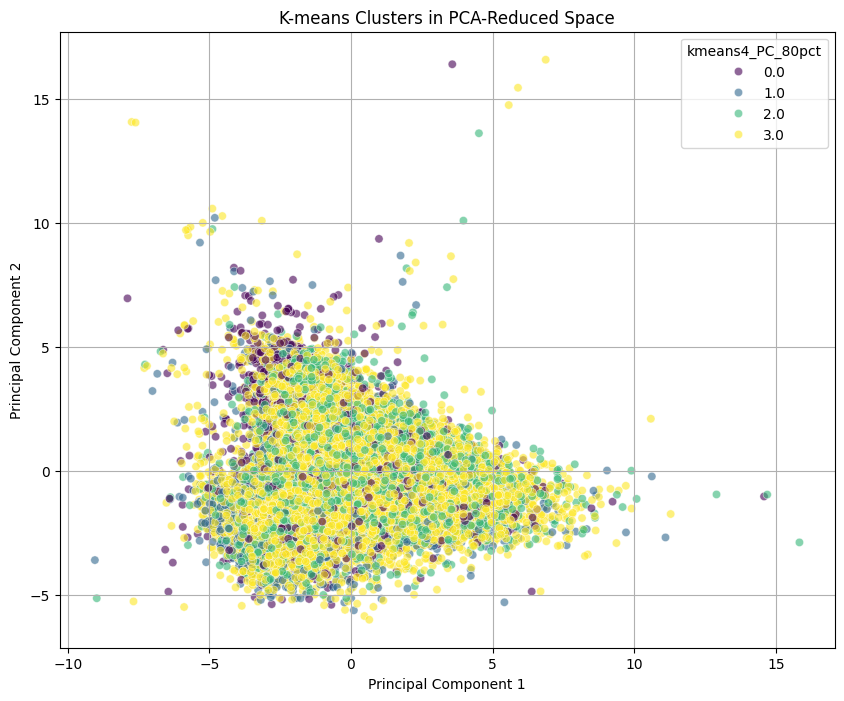

Scatter plot of K-means clusters in PCA-reduced space has been generated.


In [27]:
# Create a DataFrame for plotting with PCA components and cluster labels
df_plot = pd.DataFrame(data = df_pca[:,0:2], columns = ['Principal Component 1', 'Principal Component 2'])
df_plot['kmeans4_PC_80pct'] = df['kmeans4_PC_80pct']

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='kmeans4_PC_80pct',
    data=df_plot,
    palette='viridis',
    legend='full',
    alpha=0.6
)
plt.title('K-means Clusters in PCA-Reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

print("Scatter plot of K-means clusters in PCA-reduced space has been generated.")

In the plots above, we can see that there are no distinct clusters forming. Lets iterate through this process and see if we can fine-tune our clusters.

Lets try to use F-statistics to reduce the dimensionality of our data more, and silhoette score to determine the right k.

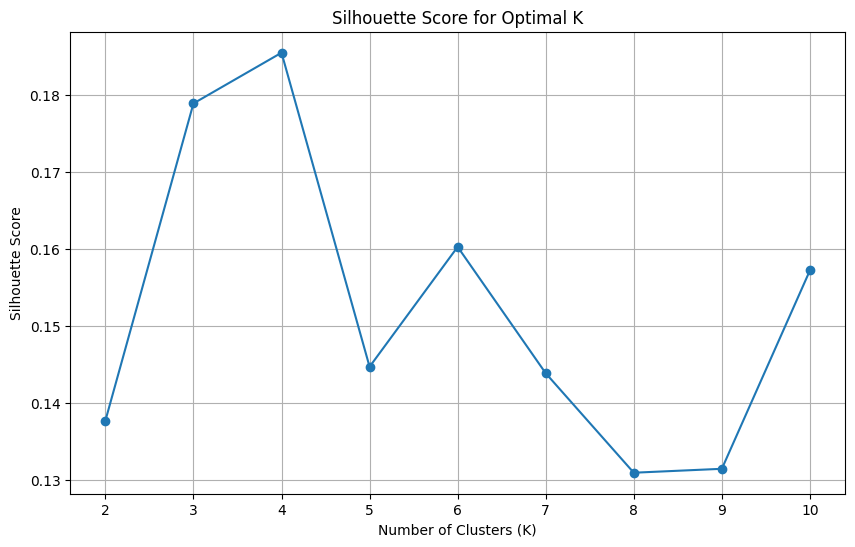

The Silhouette Score plot has been generated to help determine the optimal number of clusters.


In [28]:
# Define a range for the number of clusters (K), from 2 to 10
k_range_silhouette = range(2, 11)

# Create an empty list to store the Silhouette scores
silhouette_scores = []

# Loop through each value of k in the defined range
for k in k_range_silhouette:
    # Instantiate a KMeans object with n_clusters=k, random_state=42, and n_init='auto'
    kmeans_silhouette = KMeans(n_clusters=k, random_state=42, n_init='auto')

    # Fit the KMeans model to the PCA-transformed data
    kmeans_silhouette.fit(df_pca_adjusted)

    # Predict the cluster labels
    cluster_labels_silhouette = kmeans_silhouette.predict(df_pca_adjusted)

    # Calculate the Silhouette score and append it to the list
    score = silhouette_score(df_pca_adjusted, cluster_labels_silhouette)
    silhouette_scores.append(score)

# Create a plot with the range of K values on the x-axis and the Silhouette scores on the y-axis
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, marker='o')

# Add labels and title to the plot
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.grid(True)
plt.xticks(k_range_silhouette)

# Display the plot
plt.show()

print("The Silhouette Score plot has been generated to help determine the optimal number of clusters.")

In [29]:
optimal_k = 4

# Instantiate KMeans with the optimal K
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')

# Fit the KMeans model to the PCA-transformed data (df_pca)
kmeans_model.fit(df_pca_adjusted)

# Predict the cluster labels
cluster_labels = kmeans_model.predict(df_pca_adjusted)

df['kmeans4_PC_80pct'] = [str(i) for i in cluster_labels]

# Create a DataFrame for plotting with PCA components and cluster labels
df_plot_agg = pd.DataFrame(data = df_pca_adjusted[:,0:3], columns = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
df_plot_agg['kmeans4_PC_80pct'] = df['kmeans4_PC_80pct']

# Make cluster labels categorical (enables legend filtering)
#df_plot_agg['cluster_label'] = df_plot_agg['cluster_label'].astype(str)

fig = px.scatter_3d(
    df_plot_agg,
    x='Principal Component 1',
    y='Principal Component 2',
    z='Principal Component 3',
    color='kmeans4_PC_80pct',
    title='Clusters in Adjusted 3D PCA Space')

# Make dots smaller
fig.update_traces(marker=dict(size=3))

# Improve interaction
fig.update_layout(
    legend_title_text='Cluster',
    legend=dict(itemsizing='constant')
)

fig.show()

There still seems to be too much noise in the data. Next, I will look at F-statistic to see which Principal Compenents can help seperate our clusters.

In [30]:
# --- Feature Importance Analysis ---
X = df_pca_adjusted
y = df['kmeans4_PC_80pct']

f_stats, p_values = f_classif(X, y)

f_stats_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(X.shape[1])],
    'F-statistic': f_stats
})

f_stats_df = f_stats_df.sort_values(by='F-statistic', ascending=False)

print("Top 20 most important PCA components by F-statistic:")
print(f_stats_df.head(20))

Top 20 most important PCA components by F-statistic:
   PCA Component   F-statistic
0            PC1  40873.486301
1            PC2  19480.010728
2            PC3   8842.668396
4            PC5   3645.895228
3            PC4   3013.709578
7            PC8   1316.332863
5            PC6    808.722716
8            PC9    236.676424
10          PC11    191.328851
11          PC12    103.808828
12          PC13     90.147208
6            PC7     58.035532
9           PC10     46.703344


### Understanding the Principal Components continued\.\.

In [31]:
# Meaning: 
interpret_pc(loadings, 'PC5')


==== PC5 ====

Top Positive:
reviews_per_month    0.403598
reviews_per_year     0.388983
accommodates         0.167092
Name: PC5, dtype: float64

Top Negative:
host_response_time_ord      -0.412844
review_scores_rating        -0.356844
review_scores_cleanliness   -0.349206
Name: PC5, dtype: float64


In [32]:
# Meaning: 
interpret_pc(loadings, 'PC4')


==== PC4 ====

Top Positive:
log_dist_km_airport     0.246376
log_dist_km_downtown    0.244258
host_response_rate      0.219137
Name: PC4, dtype: float64

Top Negative:
review_scores_rating        -0.421679
review_scores_cleanliness   -0.402313
host_years                  -0.298811
Name: PC4, dtype: float64


### K\-Means Second Pass using only top 5 PCA Components by F\-Statistic

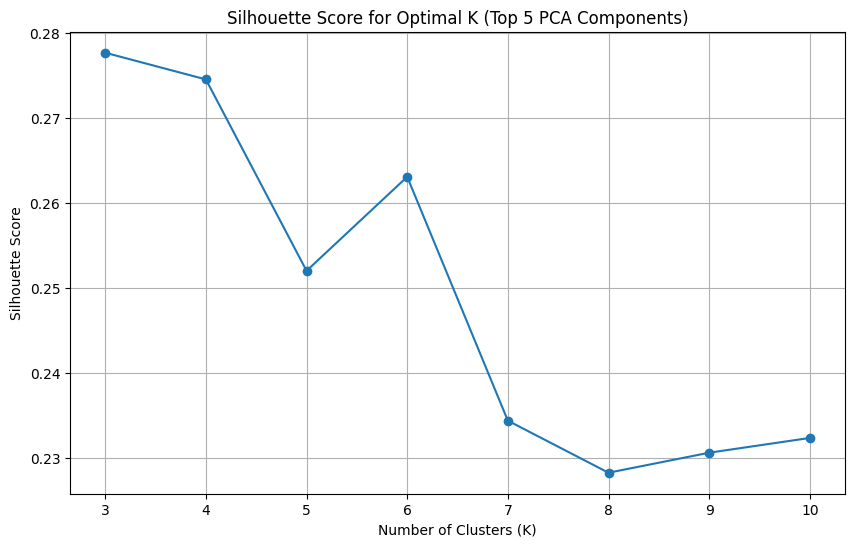

Best K by silhouette: 3
Best silhouette score: 0.2776


In [33]:
if isinstance(df_pca_adjusted, np.ndarray):
    df_pca_adjusted = pd.DataFrame(
        df_pca_adjusted,
        columns=[f"Principal Component {i}" for i in range(1, df_pca_adjusted.shape[1] + 1)]
    )

pca_cols = [
    "Principal Component 1",
    "Principal Component 2",
    "Principal Component 3",
    "Principal Component 5",
    "Principal Component 4"
]

X = df_pca_adjusted[pca_cols].to_numpy()

# ===============================
# Silhouette analysis for K = 2–10
# ===============================
n_samples = X.shape[0]
k_min = 3
k_max = min(10, n_samples - 1)

k_range = range(k_min, k_max + 1)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# ===============================
# Plot results
# ===============================
plt.figure(figsize=(10, 6))
plt.plot(list(k_range), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K (Top 5 PCA Components)')
plt.grid(True)
plt.xticks(list(k_range))
plt.show()

# ===============================
# Print best K
# ===============================
best_k = list(k_range)[int(np.argmax(silhouette_scores))]
best_score = max(silhouette_scores)

print(f"Best K by silhouette: {best_k}")
print(f"Best silhouette score: {best_score:.4f}")

In [34]:
if not isinstance(df_pca_adjusted, pd.DataFrame):
    arr = np.asarray(df_pca_adjusted)
    pc_cols = [f"Principal Component {i}" for i in range(1, arr.shape[1] + 1)]
    df_pca_adjusted = pd.DataFrame(arr, columns=pc_cols, index=df.index)
    
optimal_k = 3

X = df_pca_adjusted[pca_cols].to_numpy()

# ---- Fit KMeans at optimal K and get labels ----
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X)

# Store labels on your original df (as strings for discrete colors)
df["kmeans3_PC_top5"] = cluster_labels.astype(str)

# ---- Build plotting DF (3 PCs for 3D view) ----
plot_cols_3d = [
    "Principal Component 1",
    "Principal Component 2",
    "Principal Component 3",
]

df_plot_agg = df_pca_adjusted[plot_cols_3d].copy()
df_plot_agg["kmeans3_PC_top5"] = df["kmeans3_PC_top5"].values

# ---- Plot ----
fig = px.scatter_3d(
    df_plot_agg,
    x="Principal Component 1",
    y="Principal Component 2",
    z="Principal Component 3",
    color="kmeans3_PC_top5",
    title="KMeans Clusters in Adjusted 3D PCA Space (Interactive)",
)

# Smaller dots + a bit of opacity usually looks nicer
fig.update_traces(marker=dict(size=1, opacity=0.8))

fig.update_layout(
    legend_title_text="Cluster",
    legend=dict(itemsizing="constant")
)

fig.show()

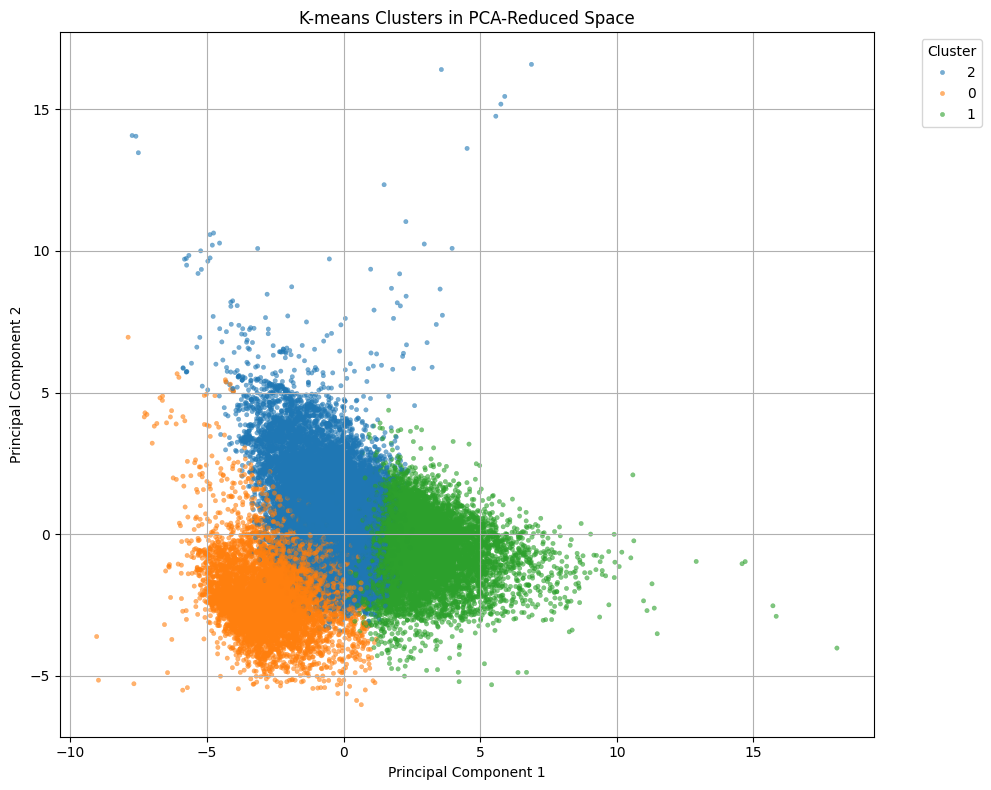

In [35]:
df_plot = df_pca_adjusted.iloc[:, 0:2].copy()
df_plot.columns = ['Principal Component 1', 'Principal Component 2']

# Add cluster labels (aligned)
df_plot['cluster'] = df['kmeans3_PC_top5'].values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_plot,
    x='Principal Component 1',
    y='Principal Component 2',
    hue='cluster',
    palette='tab10',
    s=10,
    alpha=0.6,
    edgecolor=None
)

plt.title('K-means Clusters in PCA-Reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

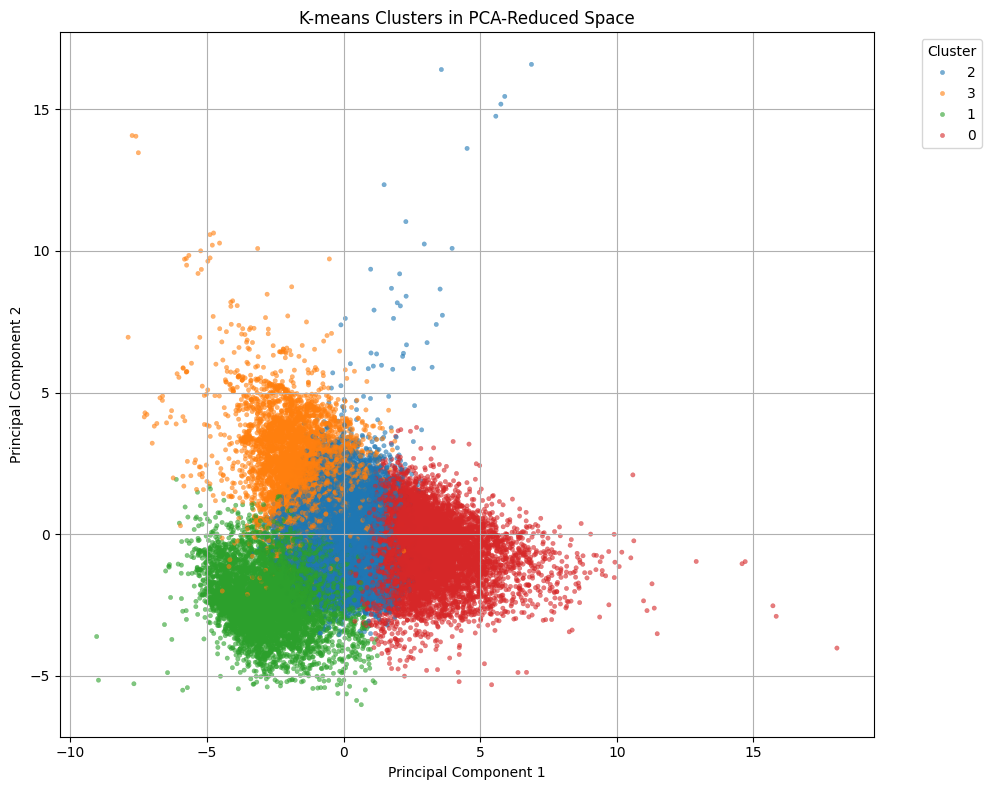

In [36]:
optimal_k = 4

X = df_pca_adjusted[pca_cols].to_numpy()

# ---- Fit KMeans at optimal K and get labels ----
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X)

# Store labels on your original df (as strings for discrete colors)
df["kmeans4_PC_top5"] = cluster_labels.astype(str)

df_plot = df_pca_adjusted.iloc[:, 0:2].copy()
df_plot.columns = ['Principal Component 1', 'Principal Component 2']

# Add cluster labels (aligned)
df_plot['cluster'] = df['kmeans4_PC_top5'].values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_plot,
    x='Principal Component 1',
    y='Principal Component 2',
    hue='cluster',
    palette='tab10',
    s=10,
    alpha=0.6,
    edgecolor=None
)

plt.title('K-means Clusters in PCA-Reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [37]:
# --- Feature Importance Analysis ---
X = df_pca_adjusted
y = df['kmeans3_PC_top5']

f_stats, p_values = f_classif(X, y)

f_stats_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(X.shape[1])],
    'F-statistic': f_stats
})

f_stats_df = f_stats_df.sort_values(by='F-statistic', ascending=False)

print("Top 20 most important PCA components by F-statistic:")
print(f_stats_df.head(20))

Top 20 most important PCA components by F-statistic:
   PCA Component   F-statistic
0            PC1  54421.761875
1            PC2  14660.439416
4            PC5   5345.444414
3            PC4   4422.003493
2            PC3   2860.878809
5            PC6    613.694875
10          PC11    285.811377
11          PC12    115.637306
7            PC8     99.938007
12          PC13     85.784612
6            PC7     29.852255
8            PC9     27.583585
9           PC10      0.894016


In [38]:
# --- Feature Importance Analysis ---
X = df_pca_adjusted
y = df['kmeans4_PC_top5']

f_stats, p_values = f_classif(X, y)

f_stats_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(X.shape[1])],
    'F-statistic': f_stats
})

f_stats_df = f_stats_df.sort_values(by='F-statistic', ascending=False)

print("Top 20 most important PCA components by F-statistic:")
print(f_stats_df.head(20))

Top 20 most important PCA components by F-statistic:
   PCA Component   F-statistic
0            PC1  40920.425706
1            PC2  18171.100436
2            PC3  10377.204888
4            PC5   3377.417887
3            PC4   3261.242153
7            PC8    572.511415
5            PC6    471.813969
10          PC11    172.598318
8            PC9    122.875118
11          PC12     69.775514
12          PC13     55.748512
6            PC7     29.285527
9           PC10      7.597423


### Sensitivity Analysis 1: difference between 3 and 4 clusters

In [39]:
df['kmeans4_mapped_to_3'] = df['kmeans4_PC_top5'].map({
    '0': '1',
    '1': '0',
    '2': '2',
    '3': '2'
})

df[['kmeans4_mapped_to_3','kmeans3_PC_top5', 'kmeans4_PC_top5']].head()

kmeans4_mapped_to_3 kmeans3_PC_top5 kmeans4_PC_top5
0                   2               2               2
1                   2               2               3
2                   2               2               3
3                   2               2               2
4                   2               2               3

In [40]:
baseline = 'kmeans3_PC_top5'
mapped   = 'kmeans4_mapped_to_3'

agreement = (df[baseline] == df[mapped]).mean()
print(f"Aligned agreement: {agreement:.3f}")

df['moved'] = (df[baseline] != df[mapped]).astype(int)
print(f"Move rate: {df['moved'].mean():.3f}")

ct = pd.crosstab(df[mapped], df[baseline])
display(ct.div(ct.sum(axis=1), axis=0).round(2))

Aligned agreement: 0.971
Move rate: 0.029


kmeans3_PC_top5         0     1     2
kmeans4_mapped_to_3                  
0                    0.99  0.00  0.01
1                    0.00  0.99  0.01
2                    0.01  0.03  0.96

In [41]:
stability_by_cluster = df.groupby(baseline)['moved'].mean().sort_values(ascending=False)
display(stability_by_cluster.to_frame('move_rate'))

move_rate
kmeans3_PC_top5           
1                 0.096246
0                 0.035254
2                 0.003604

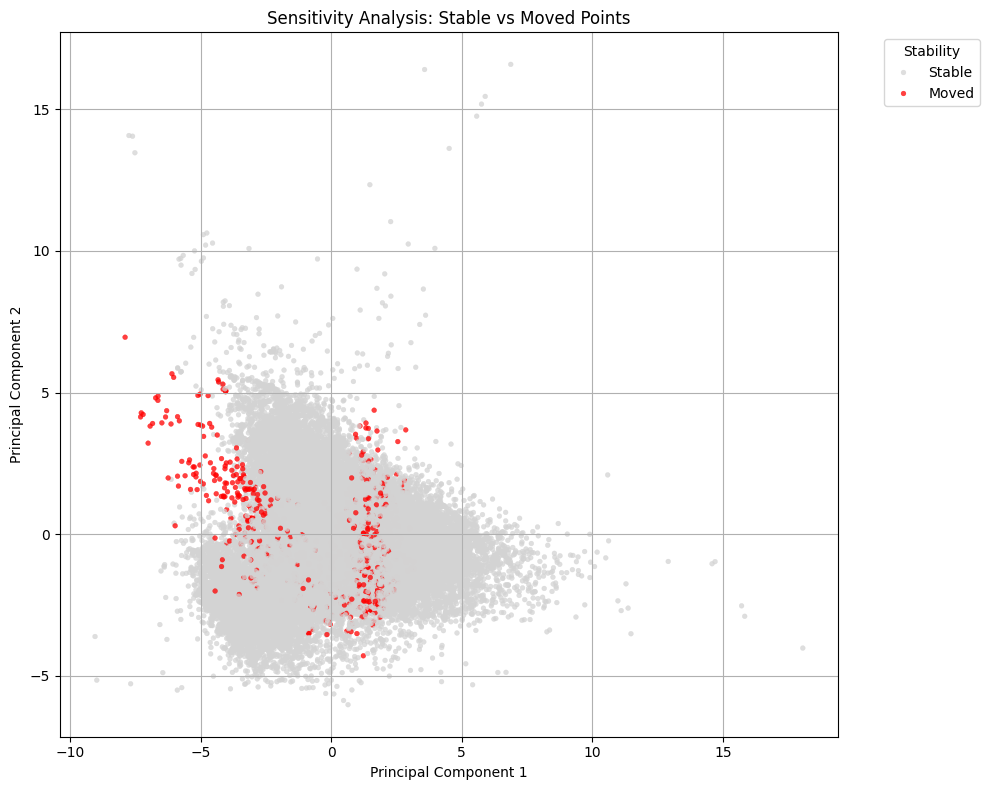

In [42]:
# Ensure moved exists (0/1)
df['stability_label'] = df['moved'].map({0: 'Stable', 1: 'Moved'})

# Build plot df (PC1 vs PC2) + stability label
df_plot = df_pca_adjusted.iloc[:, 0:2].copy()
df_plot.columns = ['Principal Component 1', 'Principal Component 2']
df_plot['stability_label'] = df['stability_label'].values  # <- important

plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_plot,
    x='Principal Component 1',
    y='Principal Component 2',
    hue='stability_label',
    hue_order=['Stable', 'Moved'],
    palette={'Stable': 'lightgray', 'Moved': 'red'},
    s=12,
    alpha=0.75,
    edgecolor=None
)

plt.title('Sensitivity Analysis: Stable vs Moved Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Stability', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Sensitivity Analysis 2: What happens when I include 1 more PC?

In [43]:
if not isinstance(df_pca_adjusted, pd.DataFrame):
    arr = np.asarray(df_pca_adjusted)
    pc_cols = [f"Principal Component {i}" for i in range(1, arr.shape[1] + 1)]
    df_pca_adjusted = pd.DataFrame(arr, columns=pc_cols, index=df.index)
    
optimal_k = 4

pca_cols = [
    "Principal Component 1",
    "Principal Component 2",
    "Principal Component 3",
    "Principal Component 5",
    "Principal Component 4",
    "Principal Component 6",

]

X = df_pca_adjusted[pca_cols].to_numpy()

# ---- Fit KMeans at optimal K and get labels ----
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X)

# Store labels on your original df (as strings for discrete colors)
df["kmeans4_PC_top6"] = cluster_labels.astype(str)

# ---- Build plotting DF (3 PCs for 3D view) ----
plot_cols_3d = [
    "Principal Component 1",
    "Principal Component 2",
    "Principal Component 3",
]

df_plot_agg = df_pca_adjusted[plot_cols_3d].copy()
df_plot_agg["kmeans4_PC_top6"] = df["kmeans4_PC_top6"].values

# ---- Plot ----
fig = px.scatter_3d(
    df_plot_agg,
    x="Principal Component 1",
    y="Principal Component 2",
    z="Principal Component 3",
    color="kmeans4_PC_top6",
    title="KMeans Clusters in Adjusted 3D PCA Space (Interactive)",
)

# Smaller dots + a bit of opacity usually looks nicer
fig.update_traces(marker=dict(size=1, opacity=0.8))

fig.update_layout(
    legend_title_text="Cluster",
    legend=dict(itemsizing="constant")
)

fig.show()

In [44]:
df['kmeans4_PC6_mapped_to_PC5'] = df['kmeans4_PC_top6'].map({
    '0': '3',
    '1': '0',
    '2': '1',
    '3': '2'
})

df[['kmeans4_PC6_mapped_to_PC5', 'kmeans4_PC_top5']].head()

kmeans4_PC6_mapped_to_PC5 kmeans4_PC_top5
0                         2               2
1                         2               3
2                         2               3
3                         2               2
4                         3               3

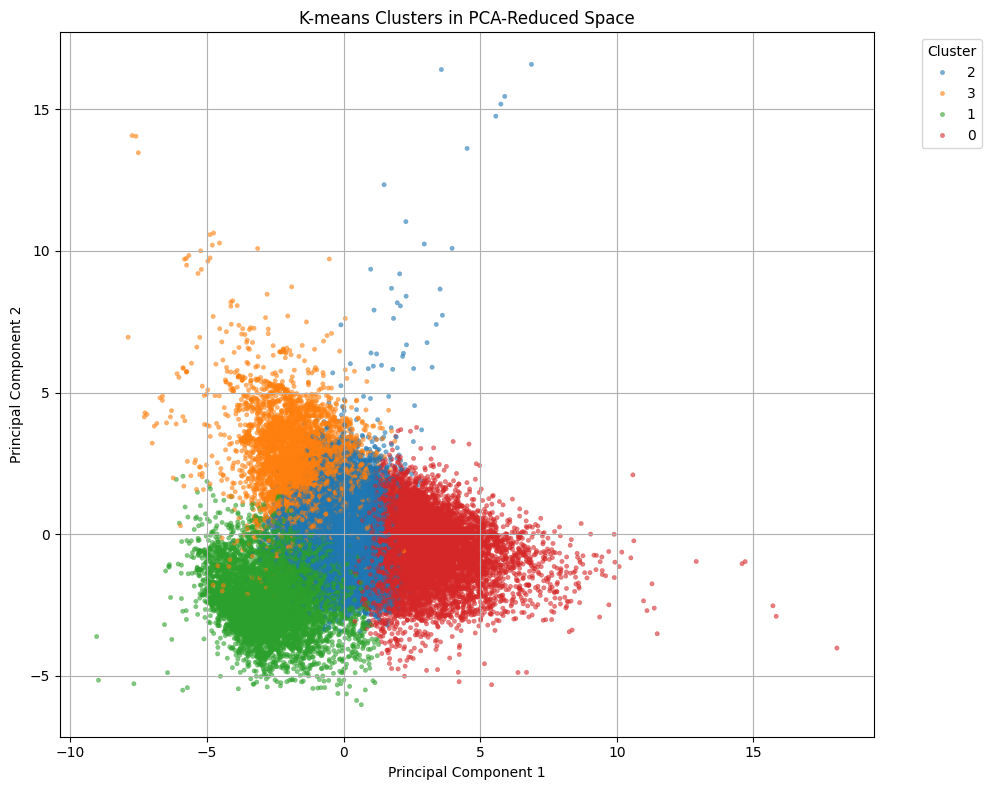

In [45]:
df_plot = df_pca_adjusted.iloc[:, 0:2].copy()
df_plot.columns = ['Principal Component 1', 'Principal Component 2']

# Add cluster labels (aligned)
df_plot['cluster'] = df['kmeans4_PC6_mapped_to_PC5'].values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_plot,
    x='Principal Component 1',
    y='Principal Component 2',
    hue='cluster',
    palette='tab10',
    s=10,
    alpha=0.6,
    edgecolor=None
)

plt.title('K-means Clusters in PCA-Reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
baseline = 'kmeans4_PC_top5'
mapped   = 'kmeans4_PC6_mapped_to_PC5'

agreement = (df[baseline] == df[mapped]).mean()
print(f"Aligned agreement: {agreement:.3f}")

df['moved'] = (df[baseline] != df[mapped]).astype(int)
print(f"Move rate: {df['moved'].mean():.3f}")

ct = pd.crosstab(df[mapped], df[baseline])
display(ct)
display(ct.div(ct.sum(axis=1), axis=0).round(2))

Aligned agreement: 0.976
Move rate: 0.024


kmeans4_PC_top5                0     1      2     3
kmeans4_PC6_mapped_to_PC5                          
0                          10561     5    218    16
1                             17  7086     70    18
2                             89    63  26631   672
3                              2     9     75  6585

kmeans4_PC_top5               0     1     2     3
kmeans4_PC6_mapped_to_PC5                        
0                          0.98  0.00  0.02  0.00
1                          0.00  0.99  0.01  0.00
2                          0.00  0.00  0.97  0.02
3                          0.00  0.00  0.01  0.99

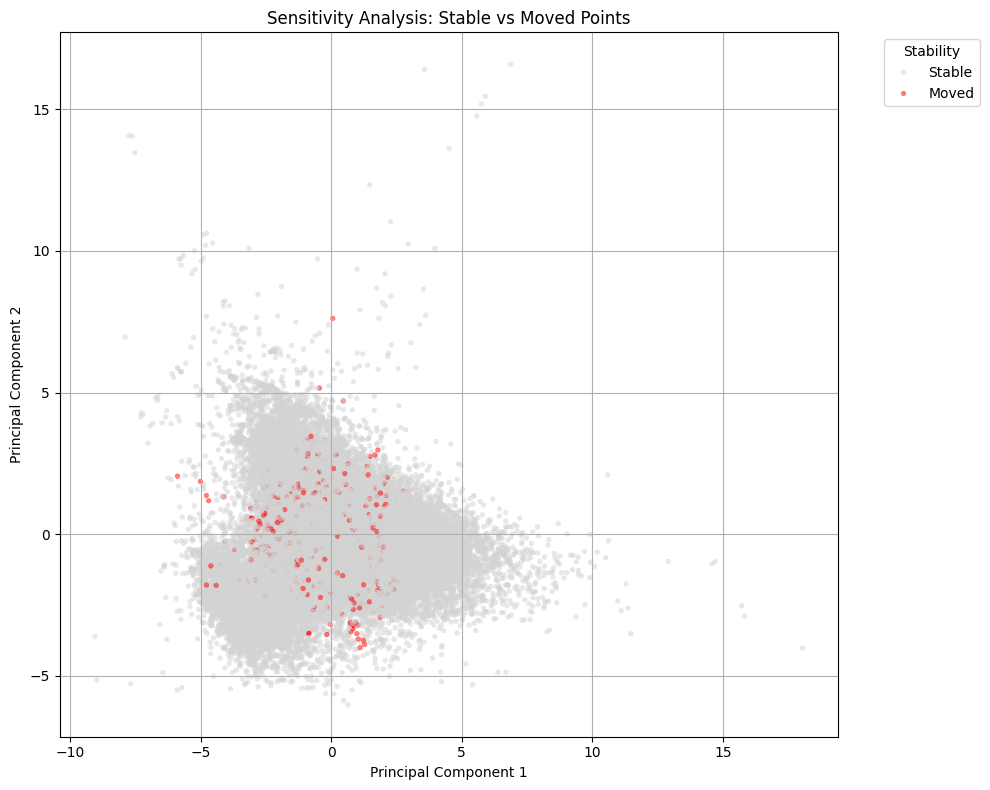

In [47]:
# Ensure moved exists (0/1)
df['stability_label'] = df['moved'].map({0: 'Stable', 1: 'Moved'})

# Build plot df (PC1 vs PC2) + stability label
df_plot = df_pca_adjusted.iloc[:, 0:2].copy()
df_plot.columns = ['Principal Component 1', 'Principal Component 2']
df_plot['stability_label'] = df['stability_label'].values  # <- important

plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_plot,
    x='Principal Component 1',
    y='Principal Component 2',
    hue='stability_label',
    hue_order=['Stable', 'Moved'],
    palette={'Stable': 'lightgray', 'Moved': 'red'},
    s=12,
    alpha=0.5,
    edgecolor=None
)

plt.title('Sensitivity Analysis: Stable vs Moved Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Stability', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Evaluation Metrics

In [48]:
# Top 5 PCs
pc5_cols = [
    "Principal Component 1",
    "Principal Component 2",
    "Principal Component 3",
    "Principal Component 5",
    "Principal Component 4",
]

# Top 6 PCs
pc6_cols = pc5_cols + ["Principal Component 6"]

# Feature matrices
X_all = df_pca_adjusted.select_dtypes(include=[np.number])   # all PCA columns (numeric only)
X_pc5 = df_pca_adjusted[pc5_cols]
X_pc6 = df_pca_adjusted[pc6_cols]

# Labels (update if your labels live in df_pca_adjusted instead of df)
labels_80_k4   = df["kmeans4_PC_80pct"]
labels_top5_k3 = df["kmeans3_PC_top5"]
labels_top5_k4 = df["kmeans4_PC_top5"]
labels_top6_k4 = df["kmeans4_PC_top6"]

### Silhouette Score

In [49]:
sil_results = pd.DataFrame({
    "model": [
        "80% PCs (k=4)",
        "Top 5 PCs (k=3)",
        "Top 5 PCs (k=4)",
        "Top 6 PCs (k=4)"
    ],
    "silhouette": [
        round(silhouette_score(X_all, labels_80_k4),2),
        round(silhouette_score(X_pc5, labels_top5_k3),2),
        round(silhouette_score(X_pc5, labels_top5_k4),2),
        round(silhouette_score(X_pc6, labels_top6_k4),2)
    ]
})

display(sil_results)

model  silhouette
0    80% PCs (k=4)        0.19
1  Top 5 PCs (k=3)        0.28
2  Top 5 PCs (k=4)        0.27
3  Top 6 PCs (k=4)        0.25

### WCSS

In [50]:
# --- 80% PCs (k=4) ---
tmp = X_all.copy()
tmp["cluster"] = labels_80_k4.values
centroids = tmp.groupby("cluster").mean()
wcss_80 = 0
for c in centroids.index:
    cluster_points = tmp[tmp["cluster"] == c].drop(columns=["cluster"]).values
    centroid = centroids.loc[c].values
    wcss_80 += ((cluster_points - centroid) ** 2).sum()

# --- Top 5 PCs (k=3) ---
tmp = X_pc5.copy()
tmp["cluster"] = labels_top5_k3.values
centroids = tmp.groupby("cluster").mean()
wcss_top5_k3 = 0
for c in centroids.index:
    cluster_points = tmp[tmp["cluster"] == c].drop(columns=["cluster"]).values
    centroid = centroids.loc[c].values
    wcss_top5_k3 += ((cluster_points - centroid) ** 2).sum()

# --- Top 5 PCs (k=4) ---
tmp = X_pc5.copy()
tmp["cluster"] = labels_top5_k4.values
centroids = tmp.groupby("cluster").mean()
wcss_top5_k4 = 0
for c in centroids.index:
    cluster_points = tmp[tmp["cluster"] == c].drop(columns=["cluster"]).values
    centroid = centroids.loc[c].values
    wcss_top5_k4 += ((cluster_points - centroid) ** 2).sum()

# --- Top 6 PCs (k=4) ---
tmp = X_pc6.copy()
tmp["cluster"] = labels_top6_k4.values
centroids = tmp.groupby("cluster").mean()
wcss_top6_k4 = 0
for c in centroids.index:
    cluster_points = tmp[tmp["cluster"] == c].drop(columns=["cluster"]).values
    centroid = centroids.loc[c].values
    wcss_top6_k4 += ((cluster_points - centroid) ** 2).sum()

wcss_results = pd.DataFrame({
    "model": [
        "80% PCs (k=4)",
        "Top 5 PCs (k=3)",
        "Top 5 PCs (k=4)",
        "Top 6 PCs (k=4)"
    ],
    "wcss": [wcss_80, wcss_top5_k3, wcss_top5_k4, wcss_top6_k4]
})

display(wcss_results)

model           wcss
0    80% PCs (k=4)  784727.977987
1  Top 5 PCs (k=3)  420086.895276
2  Top 5 PCs (k=4)  360638.868556
3  Top 6 PCs (k=4)  432721.742742

### Cluster Sizes

In [51]:
size_results = pd.DataFrame({
    "80% PCs (k=4)": labels_80_k4.value_counts().sort_index(),
    "Top 5 PCs (k=3)": labels_top5_k3.value_counts().sort_index(),
    "Top 5 PCs (k=4)": labels_top5_k4.value_counts().sort_index(),
    "Top 6 PCs (k=4)": labels_top6_k4.value_counts().sort_index()
}).fillna(0).astype(int)

display(size_results)

80% PCs (k=4)  Top 5 PCs (k=3)  Top 5 PCs (k=4)  Top 6 PCs (k=4)
0           5499             7375            10669             6671
1           7259            11720             7163            10800
2          10695            33022            26994             7191
3          28664                0             7291            27455

In [52]:
def cluster_balance_ratio(labels):
    counts = pd.Series(labels).value_counts()
    return counts.min() / counts.max()

print("80% PCs (k=4):", cluster_balance_ratio(labels_80_k4))
print("Top5 PCs (k=3):", cluster_balance_ratio(labels_top5_k3))
print("Top5 PCs (k=4):", cluster_balance_ratio(labels_top5_k4))
print("Top6 PCs (k=4):", cluster_balance_ratio(labels_top6_k4))

80% PCs (k=4): 0.1918434272955624
Top5 PCs (k=3): 0.2233359578462843
Top5 PCs (k=4): 0.2653552641327702
Top6 PCs (k=4): 0.24297942087051538


In [47]:
def normalized_entropy(labels):
    counts = pd.Series(labels).value_counts(normalize=True)
    H = -np.sum(counts * np.log(counts))
    H_max = np.log(len(counts))
    return H / H_max

print("80% PCs (k=4):", normalized_entropy(labels_80_k4))
print("Top5 PCs (k=3):", normalized_entropy(labels_top5_k3))
print("Top5 PCs (k=4):", normalized_entropy(labels_top5_k4))
print("Top6 PCs (k=4):", normalized_entropy(labels_top6_k4))

80% PCs (k=4): 0.8408461360523645
Top5 PCs (k=3): 0.8204861631482079
Top5 PCs (k=4): 0.8752595670645464
Top6 PCs (k=4): 0.8657823421617704


### Understanding the Cluster

In [58]:
# Columns to exclude
exclude_cols = [
    'id', 'listing_url', 'picture_url',
    'kmeans4_PC_80pct',
    'kmeans3_PC_top5',
    'kmeans4_mapped_to_3',
    'moved',
    'stability_label',
    'kmeans4_PC_top6',
    'kmeans4_PC6_mapped_to_PC5'
]

# Keep numeric columns only and exclude non-feature fields
num_cols = [
    col for col in df.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])
]

# Cluster profiles (means)
cluster_profiles = df.groupby('kmeans4_PC_top5')[num_cols].mean()

display(cluster_profiles)

host_response_rate  host_acceptance_rate  host_is_superhost  \
kmeans4_PC_top5                                                                
0                          0.909935              0.853819           0.563033   
1                         -0.963910             -0.619696           0.070222   
2                          0.956357              0.873786           0.619212   
3                          0.872963              0.786176           0.333425   

                 host_listings_count   latitude   longitude  accommodates  \
kmeans4_PC_top5                                                             
0                          30.395445  33.877921 -118.200913      8.366107   
1                           3.442412  34.360886 -118.670325      3.218344   
2                          18.142365  34.211862 -118.532518      3.073313   
3                         283.122754  35.457355 -119.911280      3.016184   

                 bathrooms  bedrooms      beds  ...  is_unique_stay  \
kmeans4_PC_top5                                 ...                   
0                 2.676961  3.508295  4.568844  ...        0.002624   
1                 0.473963  1.259668  0.640793  ...        0.010191   
2                 1.043436  1.211269  1.434096  ...        0.014855   
3                 1.042450  1.099163  1.291181  ...        0.034975   

                 population_per_sqmile  crime_per_sqmile  host_years  \
kmeans4_PC_top5                                                        
0                          9586.258387        601.851357    7.579338   
1                         14505.208328       1135.974630    9.238826   
2                         11761.633924        690.936386    8.266639   
3                         32039.666274       6580.998603    7.389683   

                 dist_km_downtown  dist_km_airport  log_dist_km_downtown  \
kmeans4_PC_top5                                                            
0                       18.412520        20.645880              2.738984   
1                       15.701605        20.072707              2.549241   
2                       16.758132        19.989194              2.651136   
3                        4.767263        14.882000              1.345733   

                 log_dist_km_airport  listing_age_years  reviews_per_year  
kmeans4_PC_top5                                                            
0                           2.839620           2.880817         11.530354  
1                           2.868079           6.173810          5.056206  
2                           2.825542           3.850110         15.050459  
3                           2.626747           3.224173          5.316460  

[4 rows x 35 columns]

In [61]:
# Cluster profiles (medians)
cluster_profiles = df.groupby('kmeans4_PC_top5')[num_cols].median()

display(cluster_profiles)

host_response_rate  host_acceptance_rate  host_is_superhost  \
kmeans4_PC_top5                                                                
0                               1.0                  0.99                1.0   
1                              -1.0                 -1.00                0.0   
2                               1.0                  0.98                1.0   
3                               1.0                  0.96                0.0   

                 host_listings_count  latitude   longitude  accommodates  \
kmeans4_PC_top5                                                            
0                                5.0  34.01236 -118.236030           8.0   
1                                1.0  34.06376 -118.339040           2.0   
2                                3.0  34.03997 -118.308480           2.0   
3                               11.0  34.10062 -118.389199           2.0   

                 bathrooms  bedrooms  beds  ...  is_unique_stay  \
kmeans4_PC_top5                             ...                   
0                      2.5       3.0   4.0  ...             0.0   
1                      0.0       1.0   0.0  ...             0.0   
2                      1.0       1.0   1.0  ...             0.0   
3                      1.0       1.0   1.0  ...             0.0   

                 population_per_sqmile  crime_per_sqmile  host_years  \
kmeans4_PC_top5                                                        
0                          8283.181811        268.934474        8.35   
1                         11391.801628        489.543222        9.61   
2                         10421.456873        362.246250        9.07   
3                         26589.588859       4509.772993        8.19   

                 dist_km_downtown  dist_km_airport  log_dist_km_downtown  \
kmeans4_PC_top5                                                            
0                       13.908200        16.741922              2.701911   
1                       12.819950        17.898863              2.626113   
2                       13.430018        16.219974              2.669311   
3                        2.025497        17.600095              1.107075   

                 log_dist_km_airport  listing_age_years  reviews_per_year  
kmeans4_PC_top5                                                            
0                           2.875930           2.057534          7.702922  
1                           2.939102           6.463014          1.726040  
2                           2.846070           2.832877          8.933133  
3                           2.923167           2.232877          2.185629  

[4 rows x 35 columns]

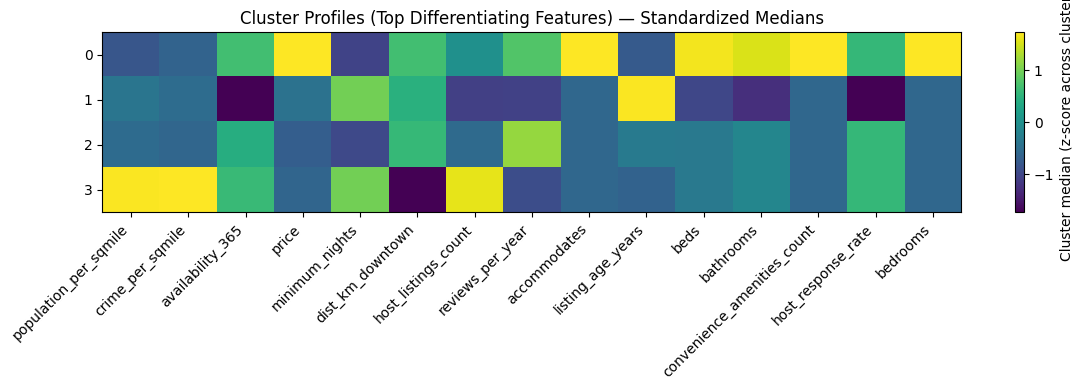

In [70]:
# (A) pick top differentiating features to avoid a giant unreadable plot
top_n = 15
feature_spread = (cluster_profiles.max(axis=0) - cluster_profiles.min(axis=0)).sort_values(ascending=False)
top_features = feature_spread.head(top_n).index

# (B) z-score across clusters for each feature (so colors are comparable)
Z = (cluster_profiles[top_features] - cluster_profiles[top_features].mean()) / cluster_profiles[top_features].std(ddof=0)

plt.figure(figsize=(12, 4))
plt.imshow(Z.values, aspect='auto')
plt.yticks(range(Z.shape[0]), Z.index)
plt.xticks(range(Z.shape[1]), Z.columns, rotation=45, ha='right')
plt.colorbar(label='Cluster median (z-score across clusters)')
plt.title("Cluster Profiles (Top Differentiating Features) — Standardized Medians")
plt.tight_layout()
plt.show()

## Cluster Interpretations (K = 4, Top 5 PCs)

### Cluster 0 – Large Group Homes (High Capacity, Short-Stay Friendly)
- Largest properties: ~8 guests, 3 bedrooms, 2.5 bathrooms
- Short minimum stay (~2 nights)
- Strong demand (high reviews per month/year)
- High guest ratings and cleanliness
- Moderate density and crime levels
- Located in mid-distance suburban / residential areas

**Summary:** Large, high-quality homes designed for groups or families that book steadily.

---

### Cluster 1 – Long-Stay / Low-Turnover Units
- Small units (~2 guests, 1 bedroom)
- Long minimum stay (~30 nights)
- Very low review activity (low booking frequency)
- Highest listing age (older inventory)
- Often low availability (frequently blocked or occupied)
- Located in moderately dense urban areas

**Summary:** Monthly or long-term rental–style listings with low turnover.

---

### Cluster 2 – High-Demand Standard 1BRs
- Typical size (~2 guests, 1 bed/1 bath)
- Short minimum stay (~3 nights)
- Highest booking activity (highest reviews per month/year)
- Very strong ratings and cleanliness
- Moderate urban density

**Summary:** Core “classic Airbnb” units that book frequently and perform well.

---

### Cluster 3 – Dense Urban Core, Longer-Stay, Lower Performance
- Small units (~2 guests, 1 bedroom)
- Long minimum stay (~30 nights)
- Lower ratings and cleanliness (lowest among clusters)
- Low-to-moderate booking activity
- Extremely high population and crime density
- Located closest to downtown

**Summary:** Urban-core listings in very dense, high-crime areas with longer stays and weaker performance.